<a href="https://colab.research.google.com/github/rizzaesh/machine-learning-sklearn/blob/main/TextClassifications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [ ]:
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
from sklearn.model_selection import cross_val_score
import zipfile
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from numpy import array
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
!pip install catboost
from xgboost import XGBClassifier
from catboost import CatBoostClassifier 
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from time import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 100 kB/s 


# data collection
collect the data from consumerfinance.gove

In [2]:
!gdown 'https://files.consumerfinance.gov/ccdb/complaints.csv.zip'

Downloading...
From: https://files.consumerfinance.gov/ccdb/complaints.csv.zip
To: /content/complaints.csv.zip
100% 448M/448M [00:03<00:00, 141MB/s]


In [3]:
# Unzipping
# import zipfile
zip_ref = zipfile.ZipFile('complaints.csv.zip', "r")
zip_ref.extractall()
zip_ref.close()

# Work with data

In [4]:
# create data frame
import pandas as pd
df_ = pd.read_csv('/content/complaints.csv')
df_.describe()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Complaint ID
count  2.727514e+06
mean   3.195702e+06
std    1.459929e+06
min    1.000000e+00
25%    2.233430e+06
50%    3.338724e+06
75%    4.283606e+06
max    5.660052e+06

In [5]:
# take a sample
df = df_.sample(20000)

In [6]:
# factorize
df['Product'].factorize() # this is something good yum yum

(array([0, 1, 1, ..., 2, 8, 2]), Index(['Debt collection',
        'Credit reporting, credit repair services, or other personal consumer reports',
        'Mortgage', 'Credit reporting', 'Credit card or prepaid card',
        'Student loan', 'Bank account or service',
        'Checking or savings account', 'Credit card', 'Vehicle loan or lease',
        'Payday loan, title loan, or personal loan',
        'Money transfer, virtual currency, or money service', 'Consumer Loan',
        'Payday loan', 'Money transfers', 'Prepaid card',
        'Other financial service'],
       dtype='object'))

In [7]:
# factor to product
df['Product'].factorize()[1]

Index(['Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Mortgage', 'Credit reporting', 'Credit card or prepaid card',
       'Student loan', 'Bank account or service',
       'Checking or savings account', 'Credit card', 'Vehicle loan or lease',
       'Payday loan, title loan, or personal loan',
       'Money transfer, virtual currency, or money service', 'Consumer Loan',
       'Payday loan', 'Money transfers', 'Prepaid card',
       'Other financial service'],
      dtype='object')

In [8]:
# add factorize to the main collumns
# from io import StringIO

col = ['Product', 'Consumer complaint narrative']
df = df[col]
df = df[pd.notnull(df['Consumer complaint narrative'])]
df.columns = ['Product', 'Consumer_complaint_narrative']
df['category_id'] = df['Product'].factorize()[0]
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)
df.head()

Product  \
387467                                     Debt collection   
2067104                                           Mortgage   
1313379                                    Debt collection   
1904348  Credit reporting, credit repair services, or o...   
247019   Credit reporting, credit repair services, or o...   

                              Consumer_complaint_narrative  category_id  
387467   some guy name  XXXX   XXXX   XXXX  kept preten...            0  
2067104  I am filing a complaint on behalf of my sister...            1  
1313379  Received improper calls from XXXX XXXX XXXX. H...            0  
1904348  I informed the office of the attorney general ...            2  
247019   I disputed XXXX XXXX XXXX account on my Equifa...            2

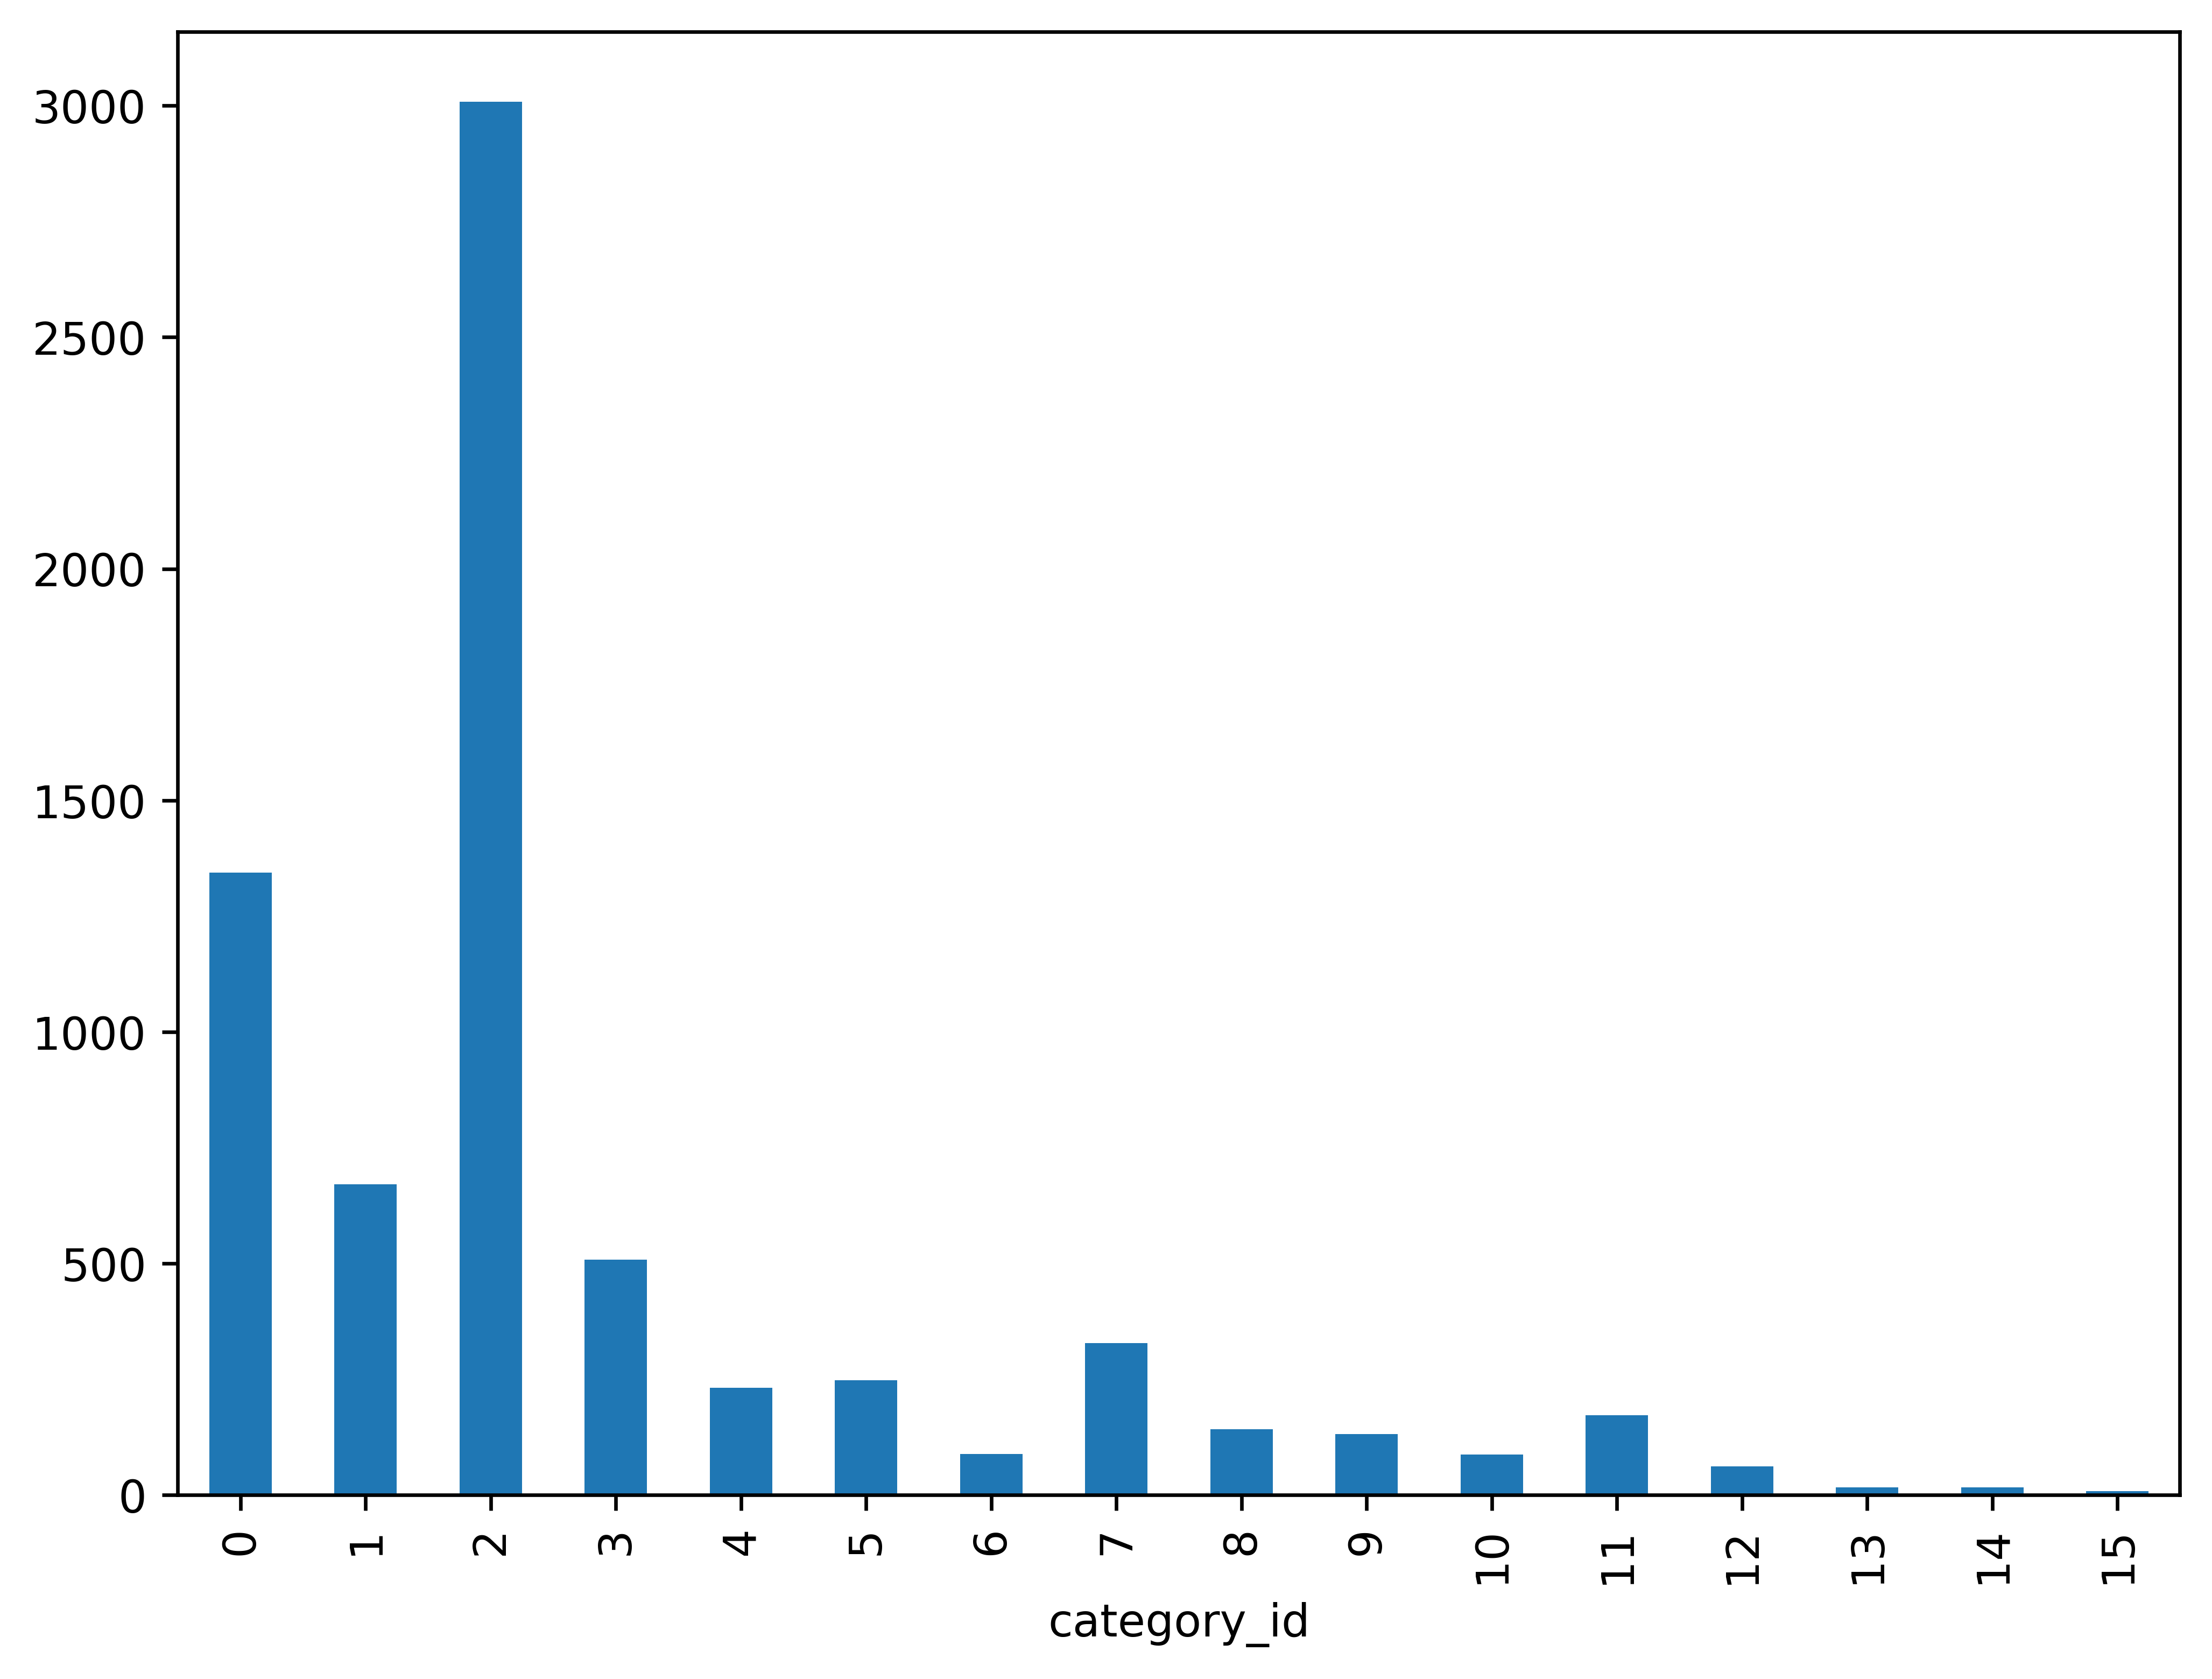

In [9]:
# Shows the plot of data
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6),dpi=600)
df.groupby('category_id').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.savefig('bar.png')
plt.show()

In [10]:
# text to vector
# from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Consumer_complaint_narrative).toarray()
labels = df.category_id
features.shape

(7062, 20612)

# work with machine

In [13]:
# shows the corralation between text things
# from sklearn.feature_selection import chi2
# import numpy as np
N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0]) # size of features
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
#   print("# '{}':".format(Product))
#   print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
#   print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [17]:
# check with a simple machine
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB

# X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['category_id'], random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [27]:
#test
print(clf.predict(count_vect.transform(["Wells Fargo XXXX XXXX XXXX XXXX XXXX, XXXX XXX"])))

['Credit reporting, credit repair services, or other personal consumer reports']


In [28]:
# another test
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.svm import LinearSVC
# X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['category_id'], random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(df['Consumer_complaint_narrative'], df['Product'], random_state = 0)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
# clf = SVC().fit(X=X_train_tfidf, y=y_train)
clf = LinearSVC().fit(X=X_train_tfidf, y=y_train)

In [29]:
# test on test data
ypred = clf.predict(count_vect.transform(X_test))

# plotting

In [31]:
# Confusion Matrix:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
dff = pd.DataFrame(confusion_matrix(y_test, clf.predict(count_vect.transform(X_test))), columns=list(set(y_test)))
dff.index = list(set(y_test))

print('The Confusion Matrix, printed as a DataFrame:')
dff

The Confusion Matrix, printed as a DataFrame:


0    1    2    3   4   5   6   7   8   9   10  11  12  13  15  16
0    4   35    1    2   0   0   2   0   0   1   0   0   0   0   0   0
1    8  681   20   14   0  12   0   5   0  17   0   3   0   0   0   0
2    3   88  189    5   5  16   0   1   0  14   1   0   3   0   0   0
3    1   13    0  144   0   4   0   2   0   2   0   0   0   0   1   0
4    0   13    1    6  12   0   0   2   0   3   0   0   1   0   0   0
5    0    2    1    1   1  70   1   0   0   2   0   0   0   0   0   0
6    0    1    0    0   0  23   3   0   0   4   1   0   0   0   0   0
7    0    5    0    3   2   1   0  39   0   1   0   0   0   0   0   0
8    0    4    1    2   0  29   0   0  10   3   0   0   0   0   0   0
9    0   15    1    1   2  18   0   0   0  96   3   0   0   0   0   0
10   0    7    1    3   0   8   0   2   0  25   2   0   0   0   0   0
11   0    3    3    5   1   6   0   1   1   2   0   1   0   0   0   0
12   0    2    1    0   2   0   0   6   0   2   0   0   2   0   0   0
13   0    0    0    1   0   1   0   0   0   0   0   1   0   0   0   0
15   0    1    0    0   0   1   0   0   0   0   0   0   0   0   0   0
16   0    0    1    0   0   0   0   0   0   0   0   0   0   0   0   0

In [37]:
# dataframe to list
listdata = dff.values.tolist()
coname = list(dff.columns)

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.mosaicplot import mosaic
from matplotlib.patches import Patch
import itertools
from collections import deque
def nclass_classification_mosaic_plot(n_classes, results, classes):
    """
    build a mosaic plot from the results of a classification
    
    parameters:
    n_classes: number of classes
    results: results of the prediction in form of an array of arrays
    
    In case of 3 classes the prdiction could look like
    [[10, 2, 4],
     [1, 12, 3],
     [2, 2, 9]
    ]
    where there is one array for each class and each array holds the
    predictions for each class [class 1, class 2, class 3].
    
    This is just a prototype including colors for 6 classes.
    """
    class_lists = [range(n_classes)]*2
    mosaic_tuples = tuple(itertools.product(*class_lists))
    
    res_list = results[0]
    for i, l in enumerate(results):
        if i == 0:
            pass
        else:
            tmp = deque(l)
            tmp.rotate(-i)
            res_list.extend(tmp)
    data = {t:res_list[i] for i,t in enumerate(mosaic_tuples)}

    fig, ax = plt.subplots(figsize=(18, 10),dpi=600)
    plt.rcParams.update({'font.size': 16})

    font_color = '#2c3e50'
    pallet = ['#641E16','#1e3799','#633974','#4A235A','#154360','#1B4F72','#0E6251','#0B5345','#145A32','#186A3B','#7D6608','#7E5109','#784212','#6E2C00','#7B7D7D','#17202A','#424949']
    # pallet = [
    #     '#832535',
    #     '#6a89cc', 
    #     '#4a69bd', 
    #     '#1e3799', 
    #     '#0c2461',
    #     '#82ccdd',
    #     '#60a3bc',
    #     '#892398',
    #     '#832535',
    #     '#6a89cc', 
    #     '#4a69bd', 
    #     '#1e3799', 
    #     '#0c2461',
    #     '#82ccdd',
    #     '#60a3bc',
    #     '#892398',
    #     '#832535',
    #     '#6a89cc', 
    #     '#4a69bd', 
    #     '#1e3799', 
    #     '#0c2461',
    #     '#82ccdd',
    #     '#60a3bc',
    #     '#892398',
    # ]
    colors = deque(pallet[:n_classes])
    all_colors = []
    for i in range(n_classes):
        if i > 0:
            colors.rotate(-1)
        all_colors.extend(colors)

    props = {(str(a), str(b)):{'color':all_colors[i]} for i,(a, b) in enumerate(mosaic_tuples)}

    labelizer = lambda k: ' '
    p = mosaic(data, labelizer=labelizer, properties=props, ax=ax)

    title_font_dict = {
        'fontsize': 20,
        'color' : font_color,
    }
    axis_label_font_dict = {
        'fontsize': 16,
        'color' : font_color,
    }

    # ax.tick_params(axis = "x", which = "both", bottom = False, top = False)
    ax.axes.yaxis.set_ticks([])
    ax.axes.xaxis.set_ticks([])
    # ax.tick_params(axis='x', which='major', labelsize=14)
    # ax.set_xticks(np.arange(len(classes)), labels=classes)
    ax.set_title('Classification Report', fontdict=title_font_dict, pad=25)
    ax.set_xlabel('Observed Class', fontdict=axis_label_font_dict, labelpad=10)
    ax.set_ylabel('Predicted Class', fontdict=axis_label_font_dict, labelpad=35)

    legend_elements = [Patch(facecolor=all_colors[i], label=f'Class {i}') for i in range(n_classes)]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.018), fontsize=16)
    plt.savefig('mosaeik2.png')
    plt.tight_layout()
    plt.show()
    # plt.savefig('mosaeik.png')

In [72]:
# THE plot
nclass_classification_mosaic_plot(len(coname), listdata,coname)

In [47]:
# confusion matrix
from sklearn import metrics
predicted = clf.predict(count_vect.transform(X_test))
test_labels = y_test
# evaluate the accuracy
# plt.figure(figsize=(12,8),dpi=600)
# disp = metrics.ConfusionMatrixDisplay.from_predictions(test_labels, predicted)
# # disp.figure_.dpi=400

# # disp.figure_.figimage(resize=(8,8))
# disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
# plt.show()
# plt.close()

acc = metrics.accuracy_score(y_true=test_labels, y_pred=predicted)
print(acc) # 0.9611

0.7067117879300621


[[  4  35   1   2   0   0   2   0   0   1   0   0   0   0   0   0]
 [  8 681  20  14   0  12   0   5   0  17   0   3   0   0   0   0]
 [  3  88 189   5   5  16   0   1   0  14   1   0   3   0   0   0]
 [  1  13   0 144   0   4   0   2   0   2   0   0   0   0   1   0]
 [  0  13   1   6  12   0   0   2   0   3   0   0   1   0   0   0]
 [  0   2   1   1   1  70   1   0   0   2   0   0   0   0   0   0]
 [  0   1   0   0   0  23   3   0   0   4   1   0   0   0   0   0]
 [  0   5   0   3   2   1   0  39   0   1   0   0   0   0   0   0]
 [  0   4   1   2   0  29   0   0  10   3   0   0   0   0   0   0]
 [  0  15   1   1   2  18   0   0   0  96   3   0   0   0   0   0]
 [  0   7   1   3   0   8   0   2   0  25   2   0   0   0   0   0]
 [  0   3   3   5   1   6   0   1   1   2   0   1   0   0   0   0]
 [  0   2   1   0   2   0   0   6   0   2   0   0   2   0   0   0]
 [  0   0   0   1   0   1   0   0   0   0   0   1   0   0   0   0]
 [  0   1   0   0   0   1   0   0   0   0   0   0   0   0   0 

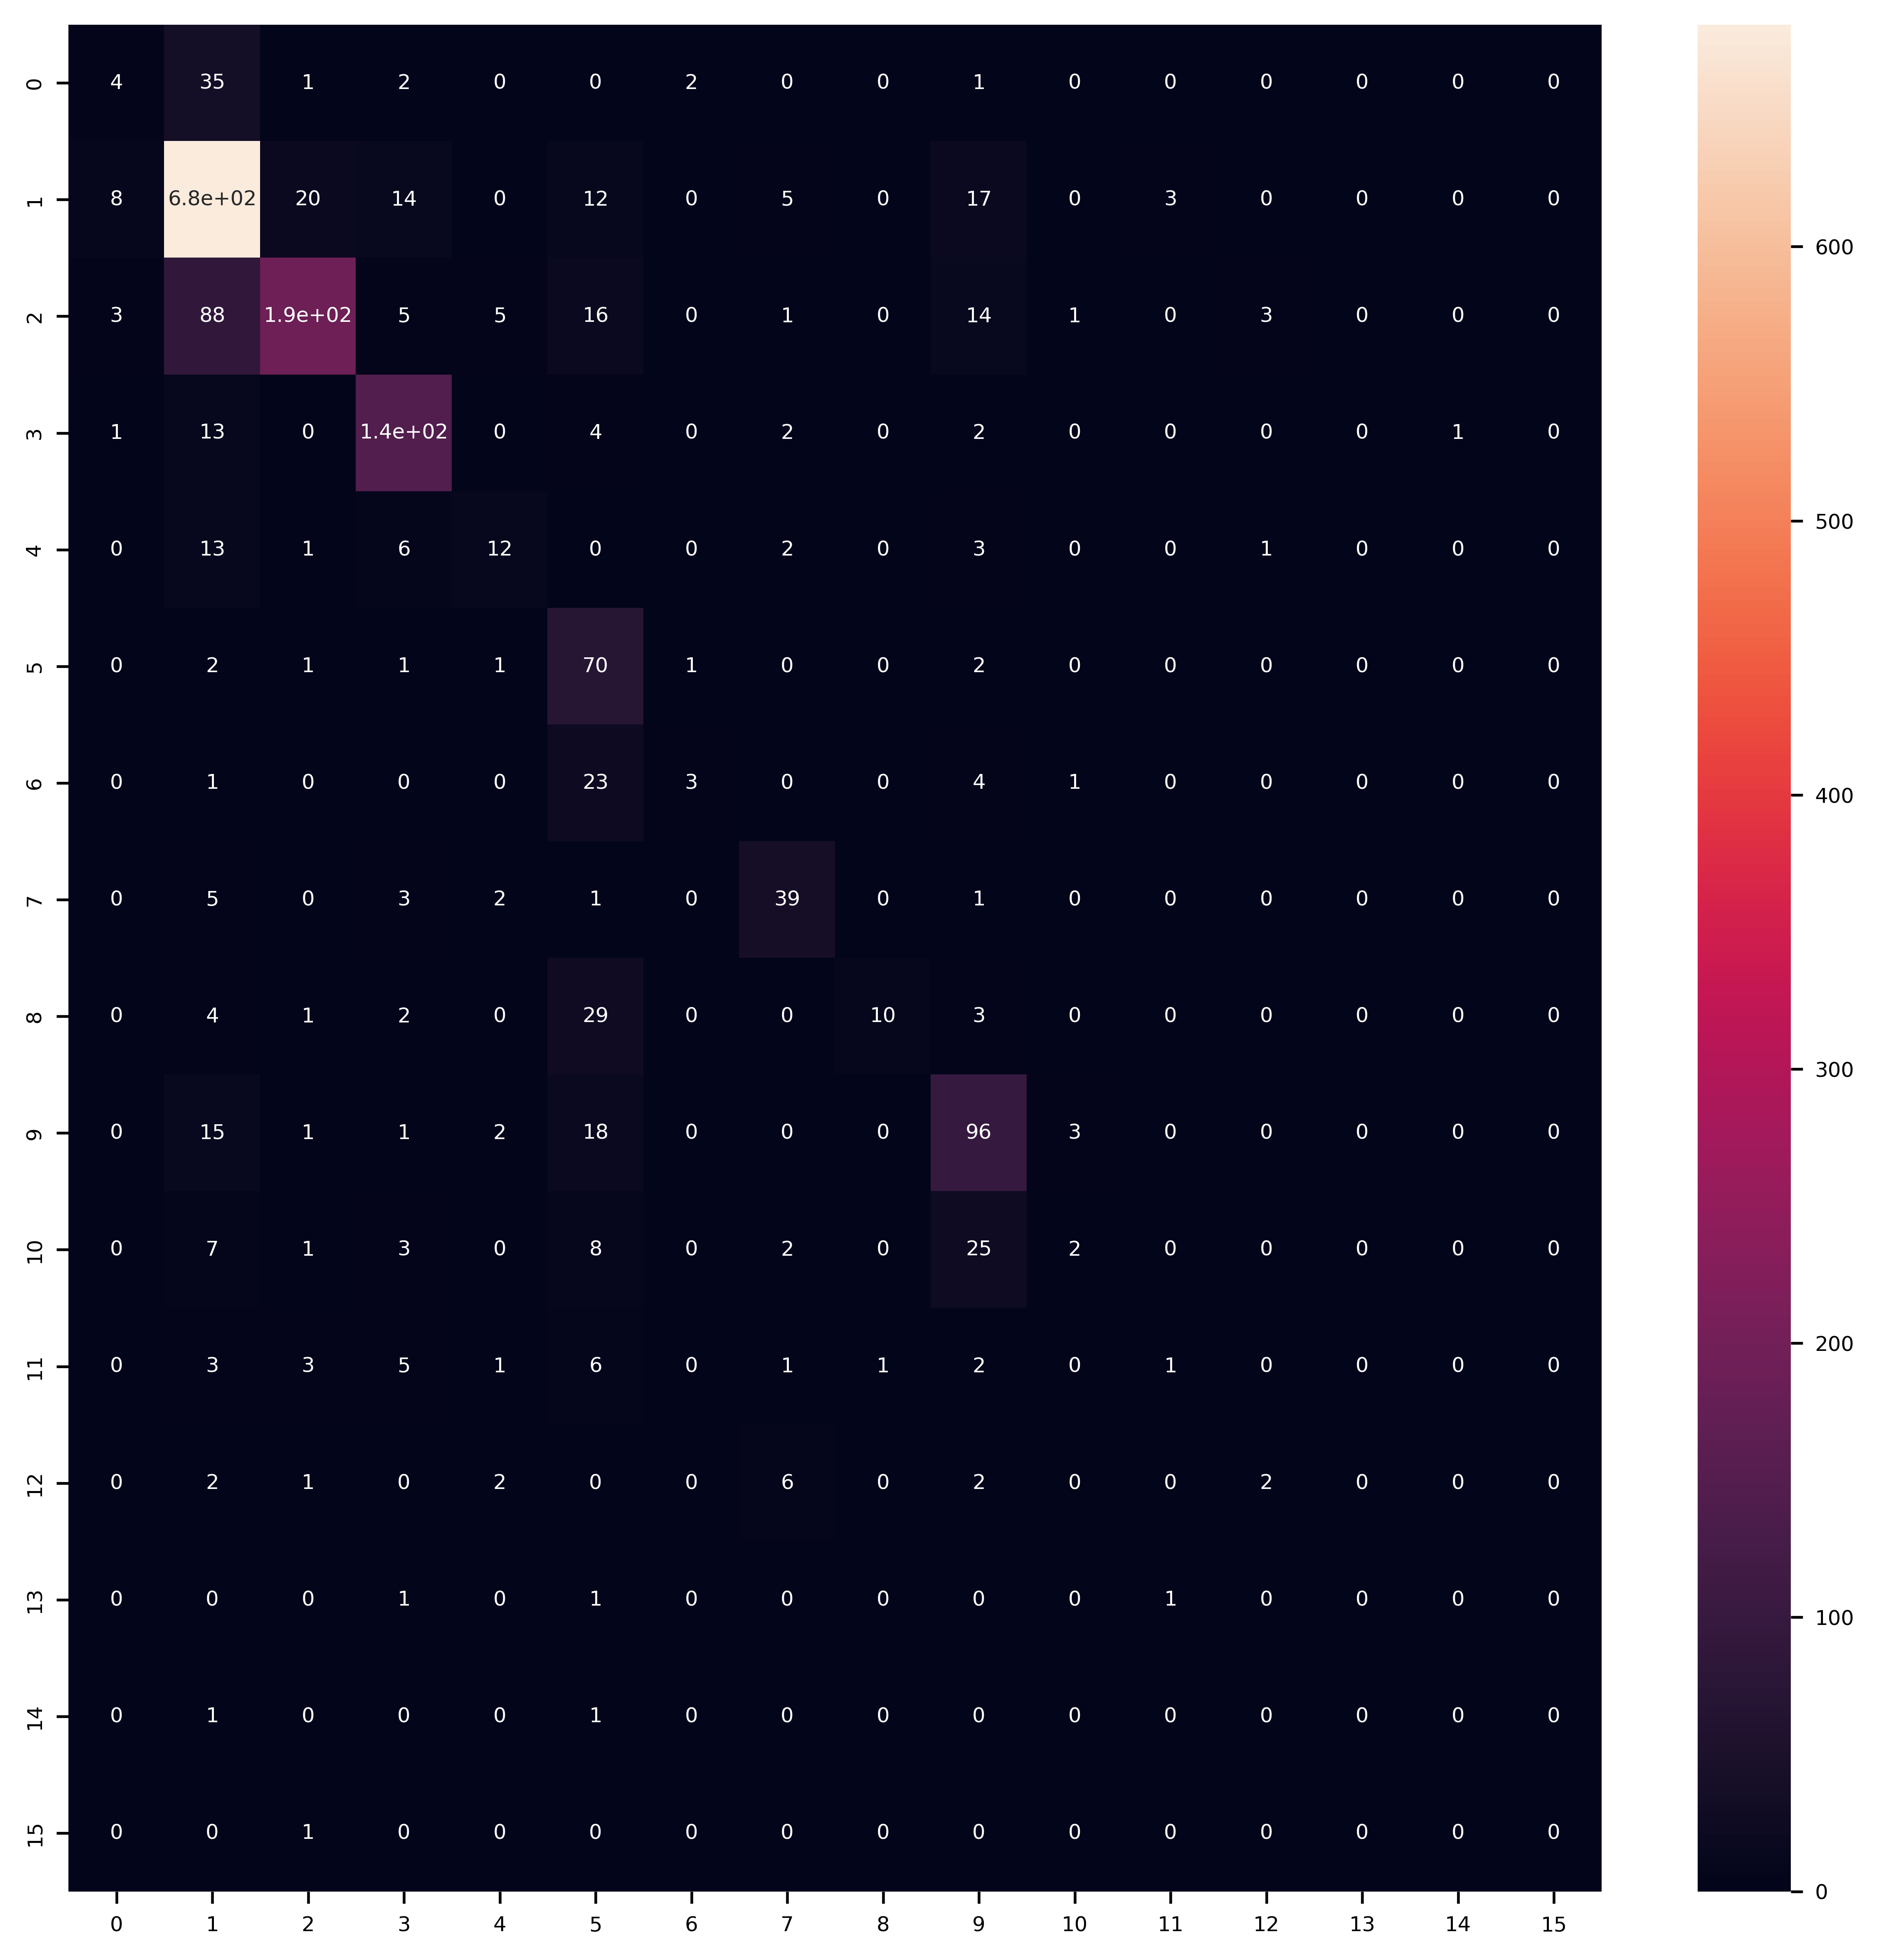

In [67]:
#Get the confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
# cf_matrix = confusion_matrix(y_test, clf.predict(count_vect.transform(X_test)))
cf_matrix = confusion_matrix(y_test, ypred)
plt.figure(figsize = (10,10),dpi=600)
plt.rcParams.update({'font.size': 6})
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)
plt.savefig('conf_seaborn.png')

Plotting the Normalized confusion matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


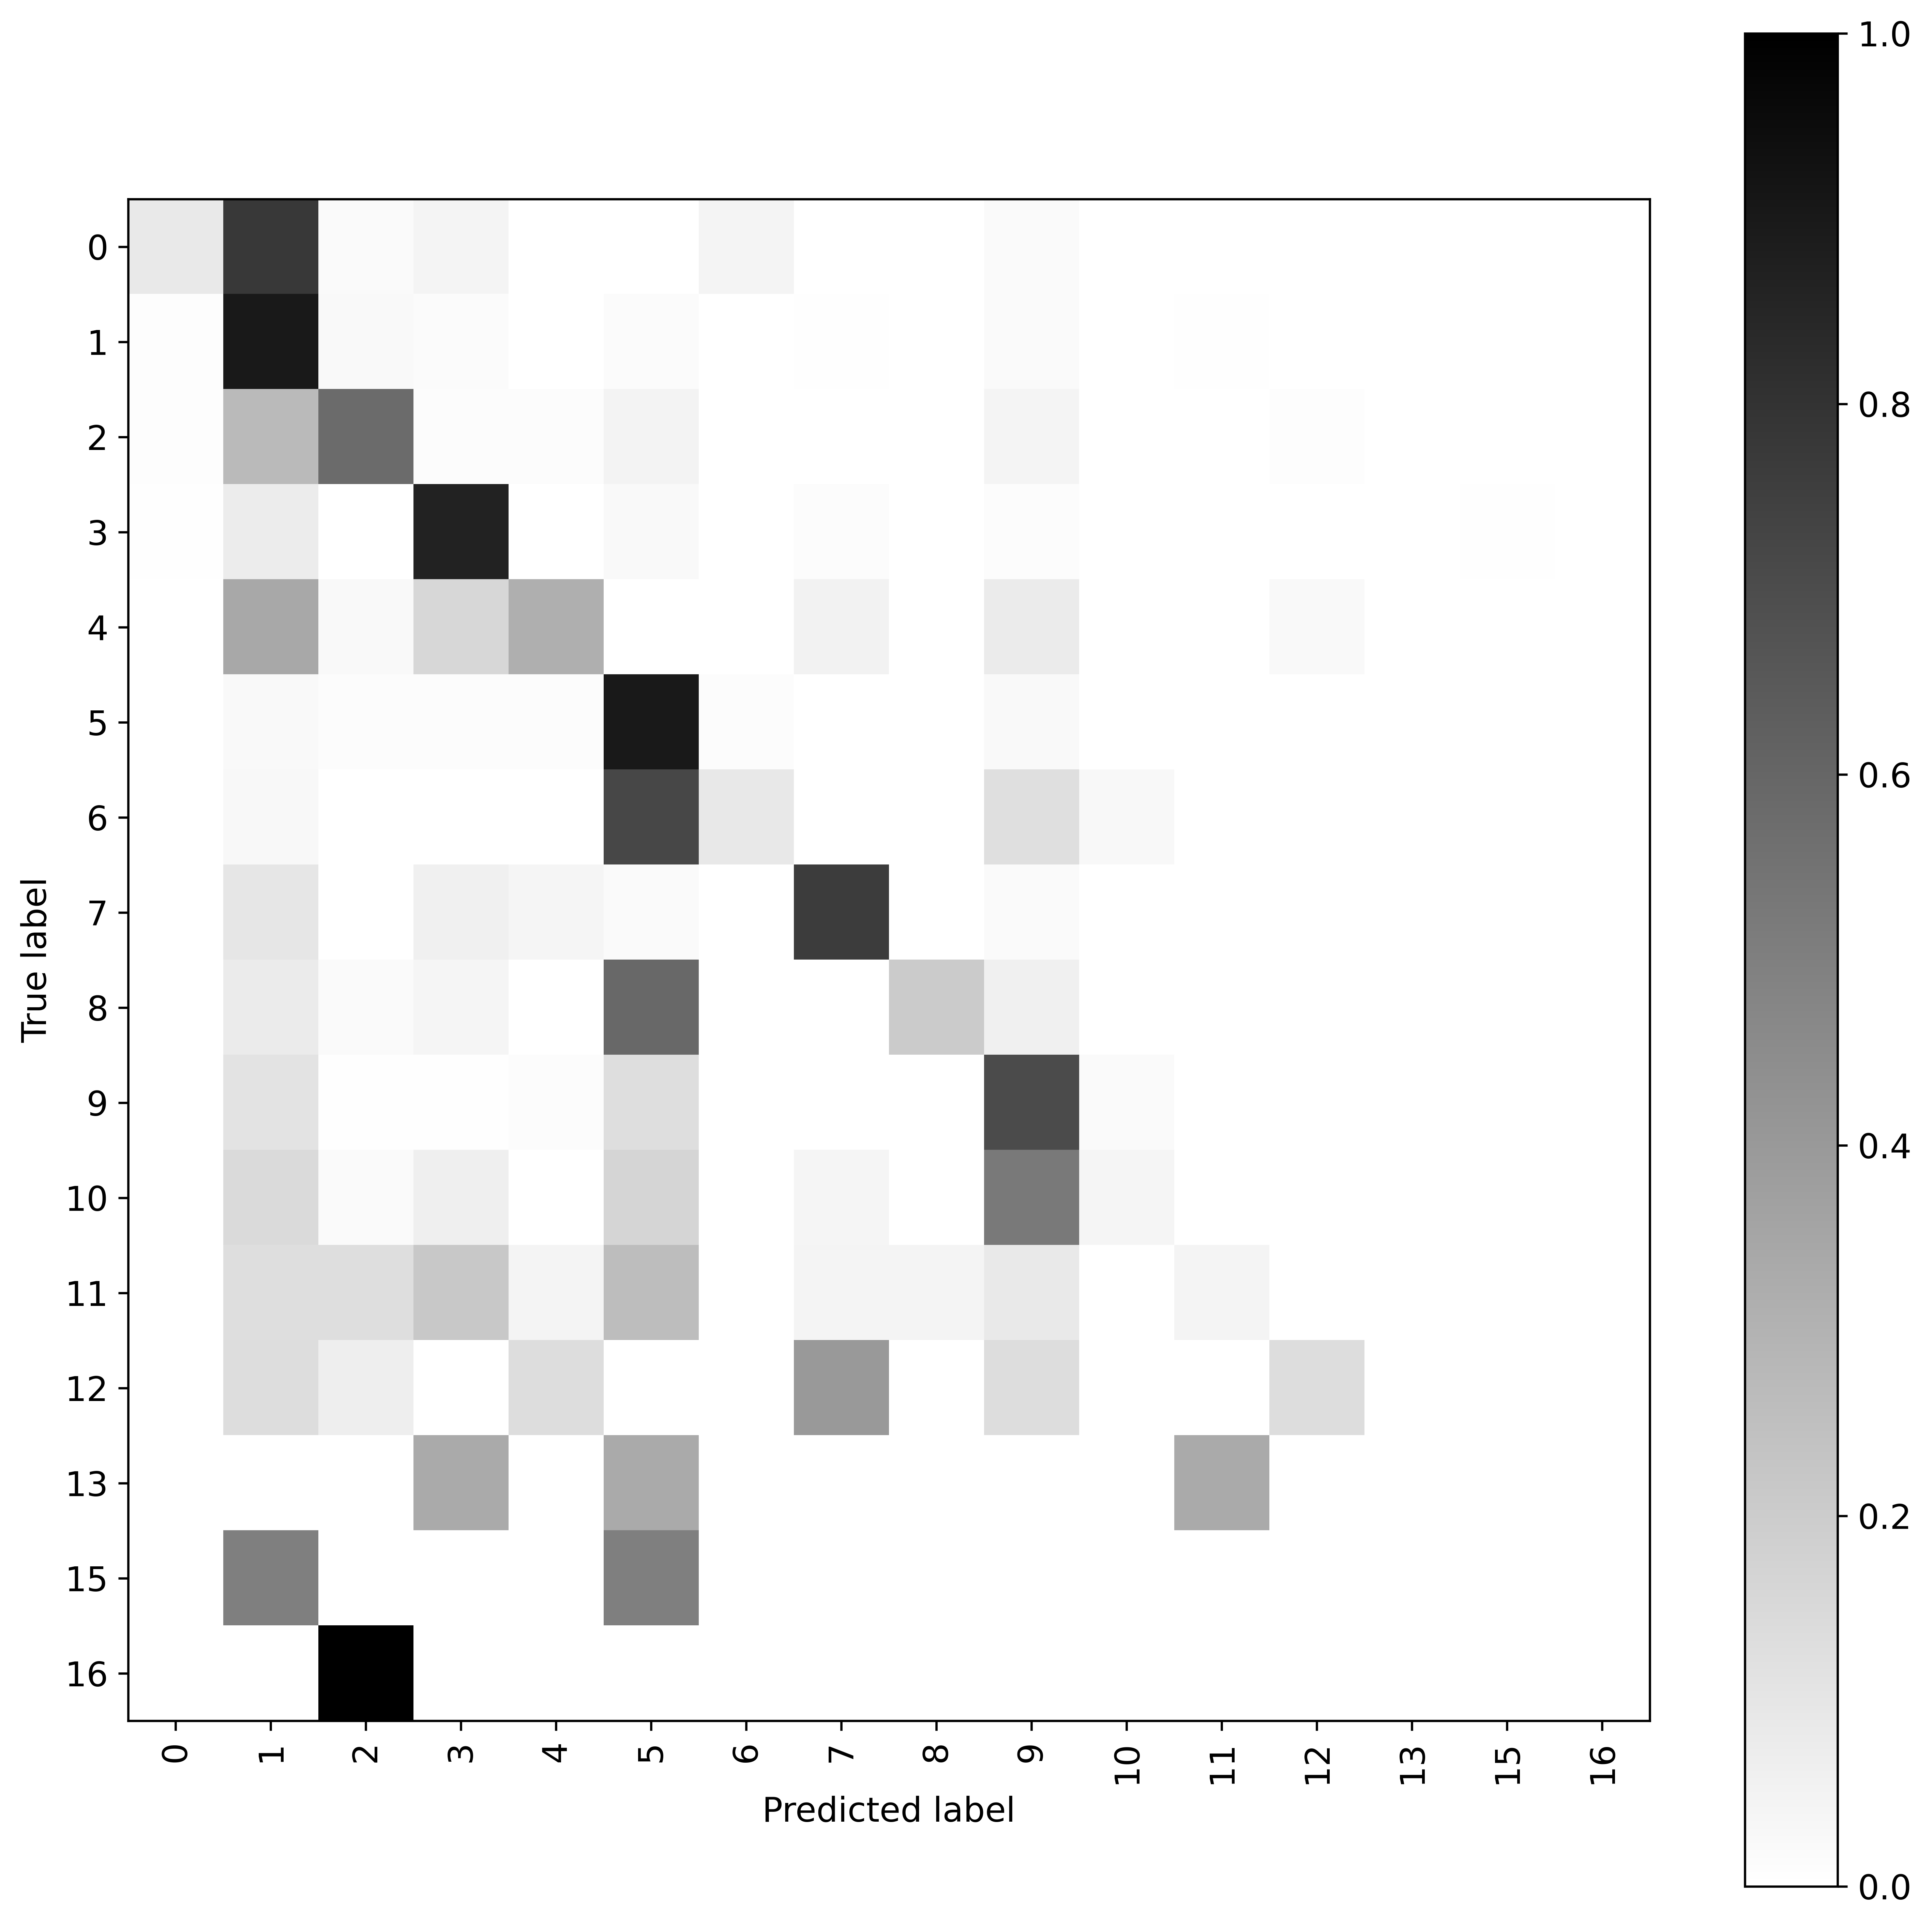

In [64]:
# Plot confusion matrix:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
print('Plotting the Normalized confusion matrix:')
# plt.figure(figsize=(8,7),dpi=600)
fig, ax = plt.subplots(figsize=(12, 12),dpi=600)
# plt.rcParams.update({'font.size': 12})
plot_confusion_matrix(clf, count_vect.transform(X_test), y_test, 
                      labels = list(set(y_test)), xticks_rotation='vertical',
                      include_values=False, normalize='true',
                      cmap='binary',ax=ax)
plt.savefig('books_read.png')

# features

In [11]:
# from sklearn.decomposition import PCA
pca = PCA(n_components=100, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto',random_state=None)
features = pca.fit_transform(features)
features.shape

(7062, 100)

In [ ]:
df

# Classification
for number of features

In [1]:
from io import StringIO
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
import numpy as np
import zipfile
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from numpy import array
import matplotlib.pyplot as plt
# create data frame
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
# from sklearn.neighbors import NearestCentroid

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns
from time import time

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
%%time

# Learning curve:

# from sklearn.metrics import mean_squared_error
# from numpy import array

scores_list = []

clf = SVC()
'''
def loss_func(Y_true, Y_prediction): # definig a loss function
    Y_true=array(Y_true)
    Y_prediction=array(Y_prediction)
    c=0
    for i in range(len(Y_true)):
        if Y_true[i]!=Y_prediction[i]: c+=1
    return c/len(Y_true)
'''
data_clean = df_
def loss_func(Y_true, Y_prediction): # definig a loss function
    return (array(Y_true)!=array(Y_prediction)).mean()

ns_list = [1000,5000,9000,13000,19000] # number of samples that we want to keep
n_avg = 3  # Number of times to average over

# sample_data = data_clean.sample(1000)
# col = ['Product', 'Consumer complaint narrative']
# sample_data = sample_data[col]
# sample_data = sample_data[pd.notnull(sample_data['Consumer complaint narrative'])]
# sample_data.columns = ['Product', 'Consumer_complaint_narrative']
# sample_data['category_id'] = sample_data['Product'].factorize()[0]

# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(sample_data.Consumer_complaint_narrative).toarray()
# labels = df.category_id
# pca = PCA(n_components=100, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto',random_state=None)
# features = pca.fit_transform(features)
labels = list(df['Product'])
for ns in ns_list:   # For different number of samples, we try training our estimator
    print(f"for {ns} number of data")


    # category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
    # category_to_id = dict(category_id_df.values)
    # id_to_category = dict(category_id_df[['category_id', 'Product']].values)
    # df.head()
    # features.shape        

    e_in = 0
    e_out = 0   # For each, we record the in and out score. 
    for i in range(n_avg):
        X_train, X_test, Y_train, Y_test = train_test_split(features[0:ns],labels[0:ns], random_state = 0)



        # pca = PCA(n_components=100)
        # X = sample_data['Consumer_complaint_narrative']

        # X = X.drop('target_tag', axis=1)
        # X = sample_data.drop('target_tag', axis=1)

        # pca_X = pca.fit_transform(X) 
        # X = sample_data.drop('text', axis=1) 
        # Y = sample_data['Product']

        # X_train, X_test, Y_train, Y_test = train_test_split(pca_X, Y)
        # clf.fit( X_train , Y_train )
        clf.fit( X_train , Y_train )

        e_in  += loss_func( Y_train, clf.predict(X_train ) ) # in-sample error
        e_out += loss_func( Y_test , clf.predict(X_test )  ) # out-sample error

        # e_in  += loss_func( Y_train, clf.predict(X_train.drop('text', axis=1) ) ) # in-sample error
        # e_out += loss_func( Y_test , clf.predict(X_test.drop('text', axis=1) )  ) # out-sample error

    scores_list += [[e_in/n_avg, e_out/n_avg]]

    
scores_list = array(scores_list)  

xlabel = 'Training samples'
ylabel = 'loss'
plt_title = 'Learning curve for classification data \n using a C-Support Vector Classifier'
fig = plt.figure(figsize=(8,6),dpi=3000)
ax2 = fig.add_subplot(111, xlabel=xlabel, ylabel=ylabel, title=plt_title)
ax2.plot(ns_list, scores_list[:,0], '-o',label = 'Training Score')
ax2.plot(ns_list, scores_list[:,1], '-o',label = 'Validation Score')
ax2.legend()
plt.savefig('learning curve_.png')
plt.show()


for 1000 number of data
for 5000 number of data
for 9000 number of data
for 13000 number of data
for 19000 number of data


CPU times: user 3min 1s, sys: 5.23 s, total: 3min 6s
Wall time: 3min 8s


In [34]:
%%time

# Learning curve:

# from sklearn.metrics import mean_squared_error
# from numpy import array


# list of models:
model_list = [
    # RandomForestClassifier(n_estimators=20, max_depth=3, random_state=0, max_features=500),
    LinearSVC(),
    # MultinomialNB(),
    SVC(),
    MLPClassifier(max_iter=500,early_stopping=True),
    XGBClassifier(),
    CatBoostClassifier(verbose=0),
    LogisticRegression(random_state=0,max_iter=1000),
]
scores_list = []

clf = LinearSVC()
'''
def loss_func(Y_true, Y_prediction): # definig a loss function
    Y_true=array(Y_true)
    Y_prediction=array(Y_prediction)
    c=0
    for i in range(len(Y_true)):
        if Y_true[i]!=Y_prediction[i]: c+=1
    return c/len(Y_true)
'''
data_clean = df_
def loss_func(Y_true, Y_prediction): # definig a loss function
    return (array(Y_true)!=array(Y_prediction)).mean()

ns_list = [1000,5000,9000,13000,19000] # number of samples that we want to keep
n_avg = 5  # Number of times to average over

# sample_data = data_clean.sample(1000)
# col = ['Product', 'Consumer complaint narrative']
# sample_data = sample_data[col]
# sample_data = sample_data[pd.notnull(sample_data['Consumer complaint narrative'])]
# sample_data.columns = ['Product', 'Consumer_complaint_narrative']
# sample_data['category_id'] = sample_data['Product'].factorize()[0]

# tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
# features = tfidf.fit_transform(sample_data.Consumer_complaint_narrative).toarray()
# labels = df.category_id
# pca = PCA(n_components=100, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto',random_state=None)
# features = pca.fit_transform(features)
labels = list(df['Product'])
duration_fit_list=[]
duration_pred_list=[]
accuracy_score_list=[]
weighted_precision_score_list=[]
weighted_recall_score_list=[]
weighted_f1_score_list=[]
entries = []
for model in model_list:   # For different number of samples, we try training our estimator
    print(f"for {model} strated.")
    clf=model
    duration_fit=0
    duration_pred=0
    accuracy_scores = 0
    weighted_precision_scores = 0
    weighted_recall_scores = 0
    weighted_f1_scores = 0

    # category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')
    # category_to_id = dict(category_id_df.values)
    # id_to_category = dict(category_id_df[['category_id', 'Product']].values)
    # df.head()
    # features.shape        

    e_in = 0
    e_out = 0   # For each, we record the in and out score. 
    for i in range(n_avg):

        X_train, X_test, Y_train, Y_test = train_test_split(features[0:10000],labels[0:10000])
        
        start_fit = time()
        clf.fit(X_train, Y_train)
        end_fit = time()
        duration_fit += end_fit - start_fit # time duration for fitting
        
        start_pred = time()
        Y_pred = clf.predict(X_test)
        end_pred = time()
        duration_pred += end_pred - start_pred # time duration for predicting
        
        accuracy_scores += round(accuracy_score(Y_test, Y_pred), 4)
        weighted_precision_scores += round(precision_score(Y_test, Y_pred, average='weighted',zero_division=1), 4)
        weighted_recall_scores += round(recall_score(Y_test, Y_pred, average='weighted'), 4)
        weighted_f1_scores += round(f1_score(Y_test, Y_pred, average='weighted'), 4)
        entries.append((model.__class__.__name__ , accuracy_score(Y_test, Y_pred),precision_score(Y_test, Y_pred, average='weighted',zero_division=1),
                        recall_score(Y_test, Y_pred, average='weighted'),f1_score(Y_test, Y_pred, average='weighted')))
    duration_fit_list.append(duration_fit/n_avg)
    duration_pred_list.append(duration_pred/n_avg)
    accuracy_score_list.append(accuracy_scores/n_avg)
    weighted_precision_score_list.append(weighted_precision_scores/n_avg)
    weighted_recall_score_list.append(weighted_recall_scores/n_avg)
    weighted_f1_score_list.append(weighted_f1_scores/n_avg)
    

model_list_name = (i.__class__.__name__ for i in model_list) # a list for the names of models

report_data = pd.DataFrame(model_list_name, columns=['model'])
report_data['fit_duration'] = duration_fit_list
report_data['pred_duration'] = duration_pred_list
report_data['accuracy'] = accuracy_score_list
report_data['weighted_precision'] = weighted_precision_score_list
report_data['weighted_recall'] = weighted_recall_score_list
report_data['weighted_f1_score'] = weighted_f1_score_list
cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy', 'weighted precision', 'weighted recall', 'weighted f1'])
report_data

for LinearSVC() strated.
for SVC() strated.
for MLPClassifier(early_stopping=True, max_iter=500) strated.
for XGBClassifier() strated.
for <catboost.core.CatBoostClassifier object at 0x7f671d249250> strated.
for LogisticRegression(max_iter=1000, random_state=0) strated.
CPU times: user 1h, sys: 23.3 s, total: 1h 24s
Wall time: 33min 25s


In [35]:

report_data

model  fit_duration  pred_duration  accuracy  \
0           LinearSVC      1.165150       0.004527   0.74102   
1                 SVC      2.543927       1.025488   0.74574   
2       MLPClassifier      2.737004       0.005560   0.74100   
3       XGBClassifier     54.444133       0.163178   0.72390   
4  CatBoostClassifier    336.501967       0.062248   0.73556   
5  LogisticRegression      1.379066       0.001462   0.71416   

   weighted_precision  weighted_recall  weighted_f1_score  
0             0.74636          0.74102            0.70428  
1             0.74756          0.74574            0.70864  
2             0.74080          0.74100            0.70588  
3             0.70650          0.72390            0.69358  
4             0.70946          0.73556            0.70420  
5             0.74790          0.71416            0.66198

In [36]:
cv_df

model_name  accuracy  weighted precision  weighted recall  \
0            LinearSVC  0.748584            0.744707         0.748584   
1            LinearSVC  0.738958            0.752591         0.738958   
2            LinearSVC  0.745753            0.750697         0.745753   
3            LinearSVC  0.730464            0.744300         0.730464   
4            LinearSVC  0.741223            0.739494         0.741223   
5                  SVC  0.754247            0.762632         0.754247   
6                  SVC  0.759909            0.775942         0.759909   
7                  SVC  0.729332            0.706747         0.729332   
8                  SVC  0.741789            0.738580         0.741789   
9                  SVC  0.743488            0.754025         0.743488   
10       MLPClassifier  0.731597            0.704589         0.731597   
11       MLPClassifier  0.741223            0.750700         0.741223   
12       MLPClassifier  0.744621            0.753824         0.744621   
13       MLPClassifier  0.738958            0.732548         0.738958   
14       MLPClassifier  0.748584            0.762381         0.748584   
15       XGBClassifier  0.716874            0.716349         0.716874   
16       XGBClassifier  0.724802            0.698469         0.724802   
17       XGBClassifier  0.725934            0.685668         0.725934   
18       XGBClassifier  0.729898            0.722260         0.729898   
19       XGBClassifier  0.721971            0.709713         0.721971   
20  CatBoostClassifier  0.731597            0.699298         0.731597   
21  CatBoostClassifier  0.733296            0.731555         0.733296   
22  CatBoostClassifier  0.736127            0.694403         0.736127   
23  CatBoostClassifier  0.727633            0.701381         0.727633   
24  CatBoostClassifier  0.749151            0.720602         0.749151   
25  LogisticRegression  0.713477            0.749046         0.713477   
26  LogisticRegression  0.696489            0.738228         0.696489   
27  LogisticRegression  0.711212            0.743989         0.711212   
28  LogisticRegression  0.730464            0.765503         0.730464   
29  LogisticRegression  0.719139            0.742815         0.719139   

    weighted f1  
0      0.711633  
1      0.699497  
2      0.708947  
3      0.694178  
4      0.707225  
5      0.717550  
6      0.724555  
7      0.691900  
8      0.703305  
9      0.705851  
10     0.694729  
11     0.704623  
12     0.714166  
13     0.702952  
14     0.712854  
15     0.686205  
16     0.695784  
17     0.694737  
18     0.699241  
19     0.691975  
20     0.702198  
21     0.701251  
22     0.704819  
23     0.693717  
24     0.719028  
25     0.660672  
26     0.641150  
27     0.659478  
28     0.678317  
29     0.670330

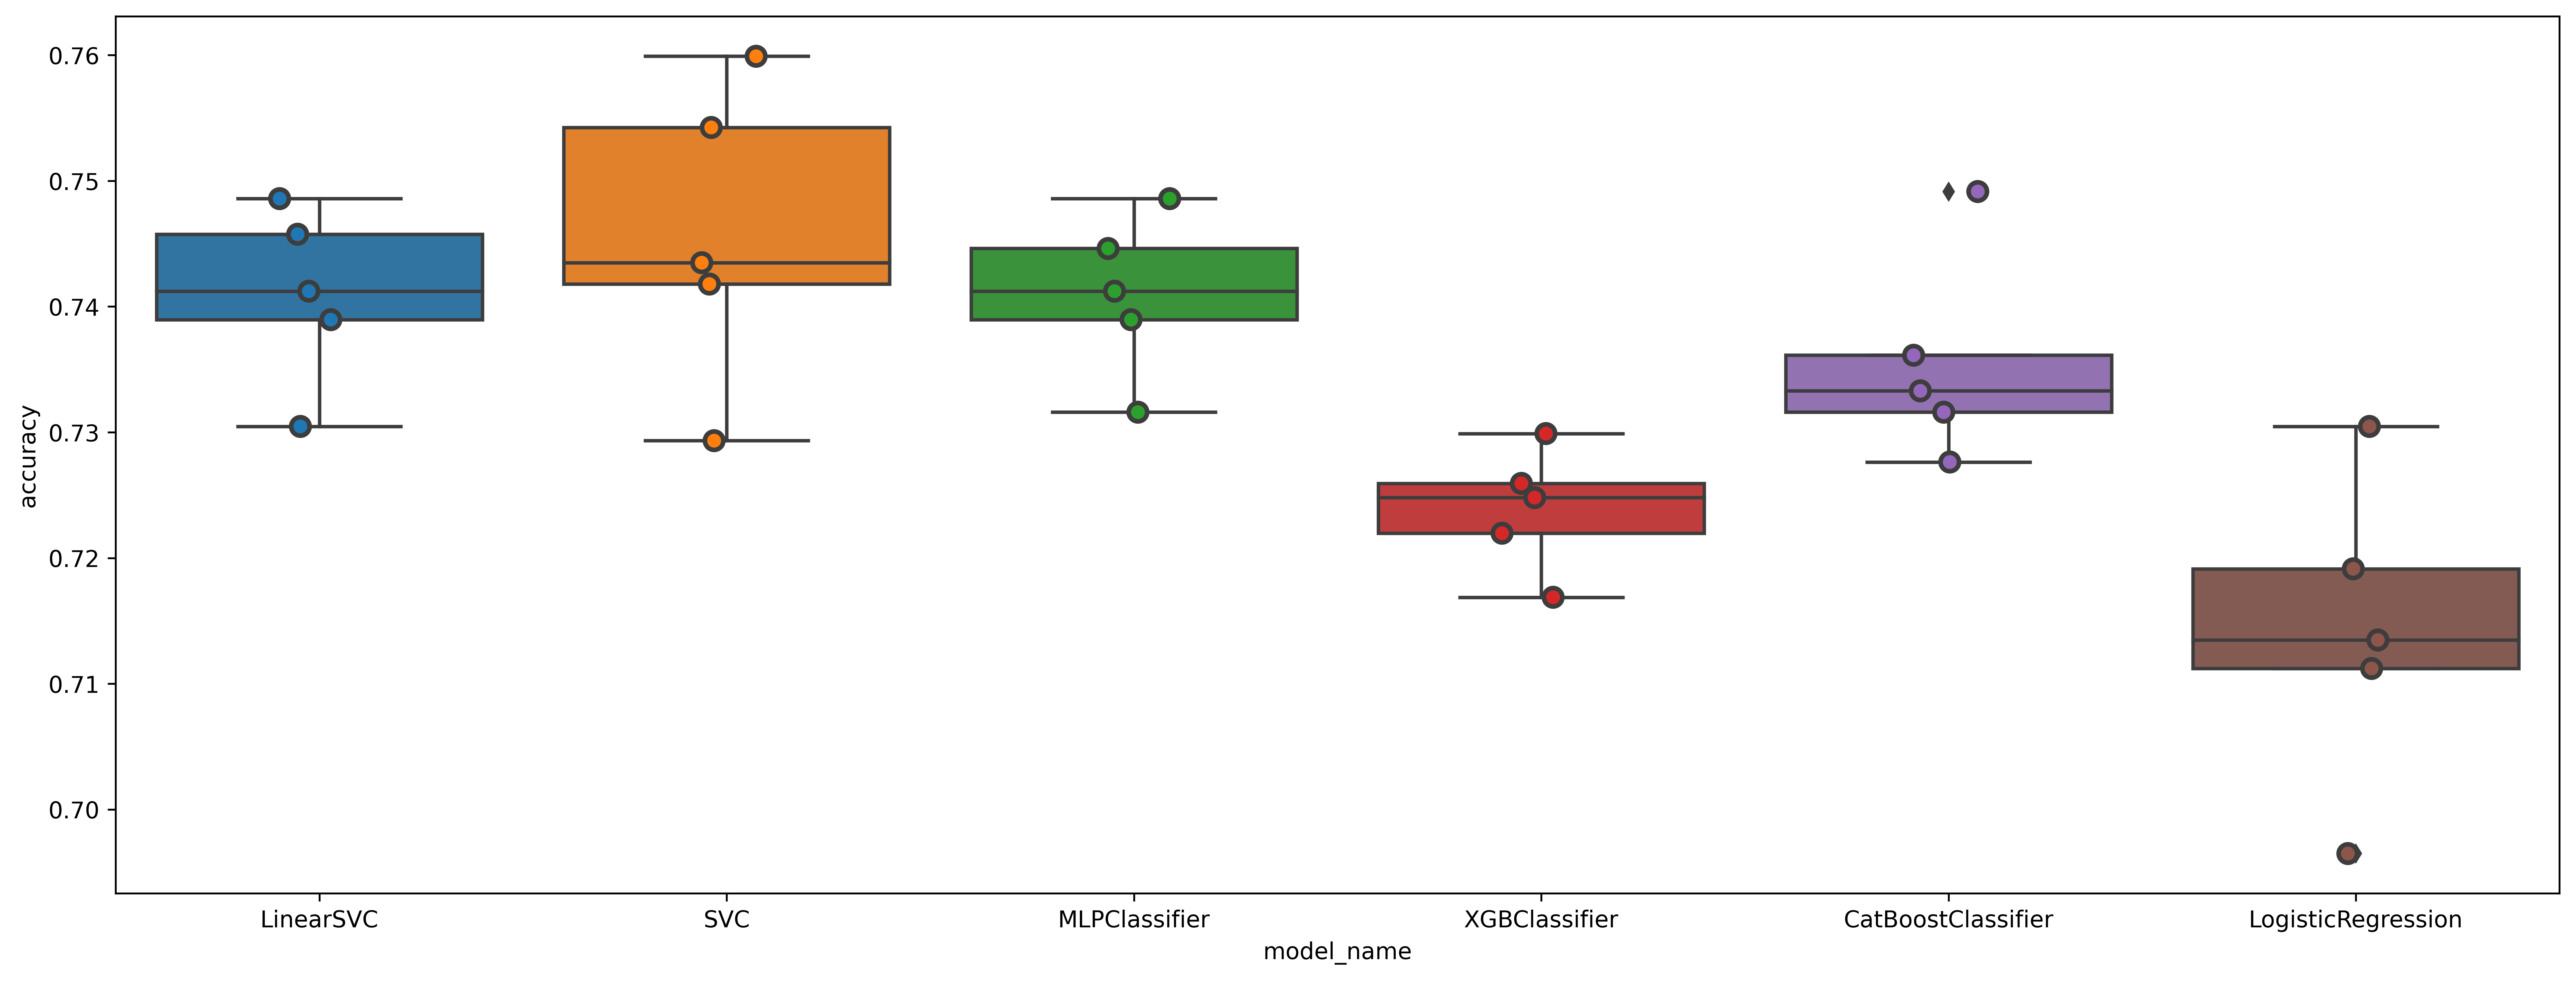

In [39]:

plt.figure(figsize=(19,7),dpi=600)
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.savefig('scores.png')
plt.show()

In [ ]:
model_list = [
    # RandomForestClassifier(n_estimators=20, max_depth=3, random_state=0, max_features=500),
    LinearSVC(),
    # MultinomialNB(),
    SVC(),
    MLPClassifier(max_iter=500,early_stopping=True),
    XGBClassifier(),
    CatBoostClassifier(verbose=0),
    LogisticRegression(random_state=0,max_iter=1000),
]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(model_list)))
entries = []
for model in model_list:
  print(model)
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [ ]:
cv_df